In [17]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPool2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.models import model_from_json
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import glob
import datetime
import numpy as np

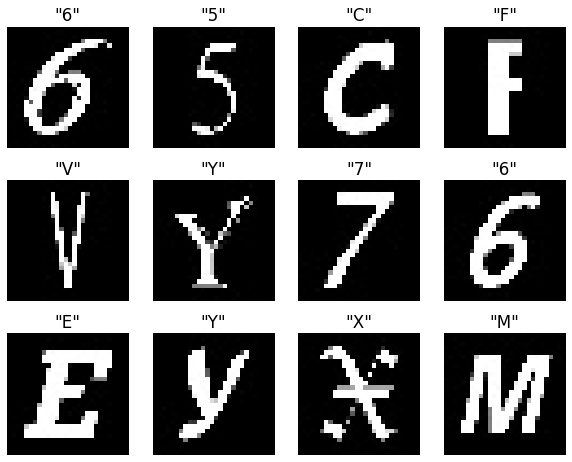

In [18]:
dataset_paths = glob.glob("dataset_characters/**/*.jpg")

cols=4
rows=3
fig = plt.figure(figsize=(10,8))
plt.rcParams.update({"font.size":14})
grid = gridspec.GridSpec(ncols=cols,nrows=rows,figure=fig)
np.random.seed(45)
rand = np.random.randint(0,len(dataset_paths),size=(cols*rows))
# Plot image
for i in range(cols*rows):
    fig.add_subplot(grid[i])
    image = load_img(dataset_paths[rand[i]])
    label = dataset_paths[rand[i]].split(os.path.sep)[-2]
    plt.title('"{:s}"'.format(label))
    plt.axis(False)
    plt.imshow(image)

plt.savefig("Visualize_dataset.jpg",dpi=300)  

In [19]:
# Arange input data and corresponding labels
X=[]
labels=[]

for image_path in dataset_paths:
  label = image_path.split(os.path.sep)[-2]
  image=load_img(image_path,target_size=(80,80))
  image=img_to_array(image)

  X.append(image)
  labels.append(label)

X = np.array(X,dtype="float16")
labels = np.array(labels)

print("[INFO] Find {:d} images with {:d} classes".format(len(X),len(set(labels))))

[INFO] Find 37623 images with 36 classes


In [20]:
# perform one-hot encoding on the labels
lb = LabelEncoder()
lb.fit(labels)
labels = lb.transform(labels)
y = to_categorical(labels)

# save label file so we can use in another script
np.save('license_character_classes_Le_Net.npy', lb.classes_)

In [22]:
#Train the model by splitting the test in ratio of 0.10
(trainX, testX, trainY, testY) = train_test_split(X, y, test_size=0.10, stratify=y, random_state=42)
print(trainX.shape)
print(testX.shape)
print(trainY.shape)

(33860, 80, 80, 3)
(3763, 80, 80, 3)
(33860, 36)


In [6]:
img_shape = ( 80, 80 , 3)

#Create a model for Training and Testing
def create_model(lr=1e-4,decay=1e-4/25, training=False,output_shape=y.shape[1]):
    model = Sequential()

    model.add(Conv2D(20, (5,5), padding="same", input_shape=img_shape, activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2) ,strides=(2,2)))

    model.add(Conv2D(50, (5,5), padding="same", activation="relu"))
    model.add(MaxPool2D(pool_size=(2,2) ,strides=(2,2)))

    model.add(Flatten())
    model.add(Dense(500, activation="relu"))
    model.add(Dense(output_shape, activation="softmax"))
   
    
    if training:
        # compile model
        optimizer = Adam(lr=lr, decay = decay)
        model.compile(loss="categorical_crossentropy", optimizer=optimizer,metrics=["accuracy"])    
        
    return model

# initilaize initial hyperparameter
INIT_LR = 1e-4
EPOCHS = 30

model = create_model(lr=INIT_LR, decay=INIT_LR/EPOCHS,training=True)

print(model.summary())

BATCH_SIZE = 64

log_dir = "./logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + 'Le_Net'

my_checkpointer = [
                EarlyStopping(monitor='val_loss', patience=5, verbose=1),
                ModelCheckpoint(filepath="License_character_recognition_Le_Net.h5", verbose=1, save_weights_only=True, restore_best_weights = True),
                TensorBoard(log_dir=log_dir, histogram_freq=1)
                ]

result = model.fit(trainX, trainY, batch_size=BATCH_SIZE, 
                   steps_per_epoch=len(trainX) // BATCH_SIZE, 
                   validation_data=(testX, testY), 
                   validation_steps=len(testX) // BATCH_SIZE, 
                   epochs=EPOCHS, callbacks=my_checkpointer, shuffle=True)

# save model architectur as json file
model_json = model.to_json()
with open("MobileNets_character_recognition_Le_Net.json", "w") as json_file:
  json_file.write(model_json)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 80, 80, 20)        1520      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 40, 40, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 40, 40, 50)        25050     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 20, 50)        0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               10000500  
_________________________________________________________________
dense_1 (Dense)              (None, 36)                1

In [1]:
#Imports Needed to Print Confusion Matrix
import matplotlib.pyplot as plt
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.models import model_from_json
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Found 87724 images belonging to 36 classes.
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']
Instructions for updating:
Please use Model.predict, which supports generators.


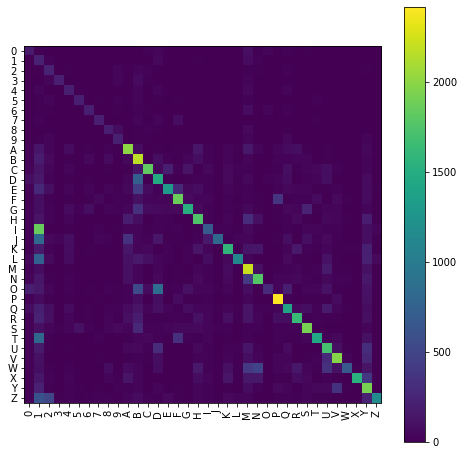

In [2]:
img_rows, img_cols, img_depth = 80,80,3
batch_size = 64
validation_data_dir = './refined_dataset/val'
nb_validation_samples = 87724

def load_model(path):
        try:
            path = splitext(path)[0]
            with open('%s.json' % path, 'r') as json_file:
                model_json = json_file.read()
            model = model_from_json(model_json, custom_objects={})
            model.load_weights('%s.h5' % path)
            print("Loading model successfully...")
            return model
        except Exception as e:
            print(e)

json_file = open('MobileNets_character_recognition_Le_Net.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
model.load_weights("License_character_recognition_Le_Net.h5")

validation_datagen = ImageDataGenerator()
validation_generator = validation_datagen.flow_from_directory(validation_data_dir,target_size=(img_rows, img_cols),batch_size=batch_size,class_mode='categorical',shuffle=False)

class_labels = validation_generator.class_indices
class_labels = {v: k for k, v in class_labels.items()}
classes = list(class_labels.values())
print(classes)

#Confusion Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)

target_names = list(class_labels.values())

plt.figure(figsize=(8,8))
cnf_matrix = confusion_matrix(validation_generator.classes, y_pred)

plt.imshow(cnf_matrix, interpolation='nearest')
plt.colorbar()
tick_marks = np.arange(len(classes))
_ = plt.xticks(tick_marks, classes, rotation=90)
_ = plt.yticks(tick_marks, classes)